## Efficiencies and working points

This notebook loads a few processed different sample parquet files as pandas dataframes and 

- plots 1d-histograms of cut variables
- attempts to determine optimum cut working points

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
sample_mapping = {}
sample_mapping['sig'] = 'GluGluHToWWToLNuQQ'

sample_mapping['dy'] = 'DYJetsToLL_Pt-250To400'
sample_mapping['wjets'] = 'WJetsToLNu_HT-200To400'
sample_mapping['qcd'] = 'QCD_Pt_300to470'

samples = ['sig', 'dy', 'wjets', 'qcd']

channels = ['ele', 'mu']

In [3]:
# processed parquets can be found here: /eos/uscms/store/user/cmantill/boostedhiggs/Jun20_2017/
# the following code just combines a few processed parquets for a few background samples for the semileptonic channels

year = '2017'

data = {}
data['ele'] = {}
data['mu'] = {}

for sample in samples:
    data['ele'][sample] = []
    data['mu'][sample] = []   
    for file in os.listdir(f"parquets/{sample_mapping[sample]}"):
        if 'ele' in file:
            if len(data['ele'][sample])==0:
                data['ele'][sample] = pq.read_table(f"parquets/{sample_mapping[sample]}/{file}").to_pandas()
            else:
                data['ele'][sample] = pd.concat([data['ele'][sample], pq.read_table(f"parquets/{sample_mapping[sample]}/{file}").to_pandas()])
        if 'mu' in file:
            if len(data['mu'][sample])==0:
                data['mu'][sample] = pq.read_table(f"parquets/{sample_mapping[sample]}/{file}").to_pandas()
            else:
                data['mu'][sample] = pd.concat([data['mu'][sample], pq.read_table(f"parquets/{sample_mapping[sample]}/{file}").to_pandas()])

In [4]:
# check the variables stored in tghe parquets
data['ele']['sig'].keys()

Index(['met', 'ht', 'nfj', 'weight', 'weight_genweight', 'weight_L1Prefiring',
       'weight_pileup', 'weight_id_electron', 'weight_reco_electron',
       'weight_trigger_electron', 'weight_ele', 'fj_pt', 'fj_msoftdrop',
       'lep_pt', 'lep_isolation', 'lep_misolation', 'lep_fj_m', 'lep_fj_dr',
       'lep_met_mt', 'met_fj_dphi', 'gen_Hpt', 'gen_Hnprongs', 'gen_iswlepton',
       'gen_iswstarlepton', 'tot_weight'],
      dtype='object')

In [5]:
for ch in channels:
    for sample in samples:
        print(f'Number of events for {sample} sample and {ch} channel is {len(data[ch][sample])}')
    print('-------------------------------------')

Number of events for sig sample and ele channel is 8563
Number of events for dy sample and ele channel is 744104
Number of events for wjets sample and ele channel is 26635
Number of events for qcd sample and ele channel is 326
-------------------------------------
Number of events for sig sample and mu channel is 13040
Number of events for dy sample and mu channel is 88677
Number of events for wjets sample and mu channel is 36955
Number of events for qcd sample and mu channel is 1953
-------------------------------------


# 1d-histograms of the following "cut" variables
- isolation
- mini-isolation
- met.pt/lep.pt cut
- dphi(met,lep)
- combining isolation and mini-isolation depending on the lepton.pt

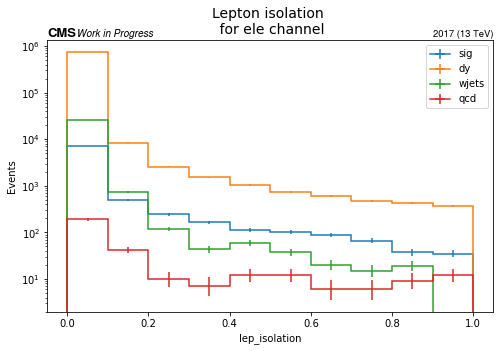

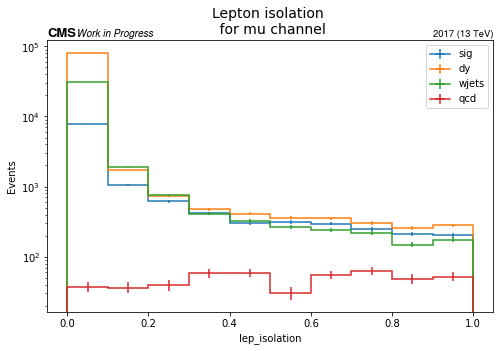

In [6]:
# isolation
hists = hist2.Hist(
    hist2.axis.Regular(10, 0, 1, name='lep_isolation', label='lep_isolation', overflow=True),
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='channels', growth=True),    
)

for ch in channels:
    for sample in samples:
        hists.fill(
            data[ch][sample]['lep_isolation'],
            sample,
            ch
        )

for ch in channels:

    fig, ax = plt.subplots(figsize=(8, 5))
    for sample in samples:
        hep.histplot(hists[{'samples':sample, 'channels': ch}], ax=ax, label=sample)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.set_title(f'Lepton isolation \n for {ch} channel', fontsize=14);
    plt.savefig(f'plots/{ch}_lep_iso.pdf')

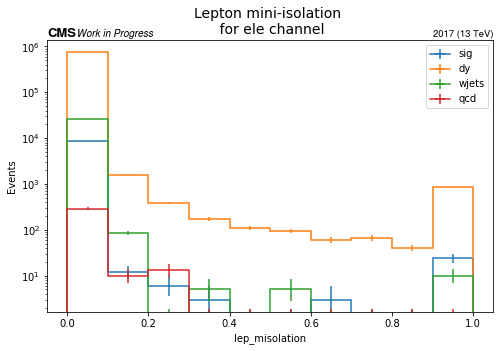

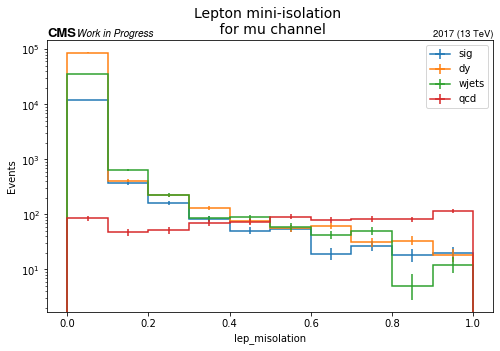

In [7]:
# misolation
hists = hist2.Hist(
    hist2.axis.Regular(10, 0, 1, name='lep_misolation', label='lep_misolation', overflow=True),
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='channels', growth=True),    
)

for ch in channels:
    for sample in samples:
        hists.fill(
            data[ch][sample]['lep_misolation'],
            sample,
            ch
        )

for ch in channels:

    fig, ax = plt.subplots(figsize=(8, 5))
    for sample in samples:
        hep.histplot(hists[{'samples':sample, 'channels': ch}], ax=ax, label=sample)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.set_title(f'Lepton mini-isolation \n for {ch} channel', fontsize=14);
    plt.savefig(f'plots/{ch}_lep_miso.pdf')  

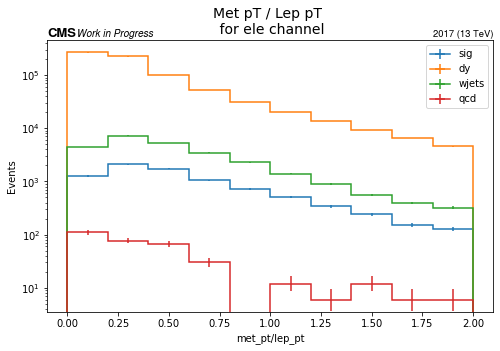

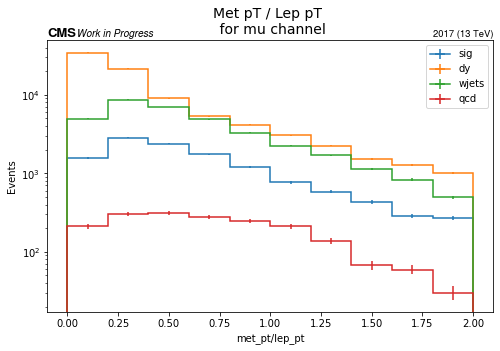

In [8]:
# met.pt/lep.pt
hists = hist2.Hist(
    hist2.axis.Regular(10, 0, 2, name='met_pt/lep_pt', label='met_pt/lep_pt', overflow=True),
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='channels', growth=True),    
)

for ch in channels:
    for sample in samples:
        hists.fill(
            data[ch][sample]['met']/data[ch][sample]['lep_pt'],
            sample,
            ch
        )

for ch in channels:

    fig, ax = plt.subplots(figsize=(8, 5))
    for sample in samples:
        hep.histplot(hists[{'samples':sample, 'channels': ch}], ax=ax, label=sample)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.set_title(f'Met pT / Lep pT \n for {ch} channel', fontsize=14);
    plt.savefig(f'plots/{ch}_met_over_lep.pdf') 

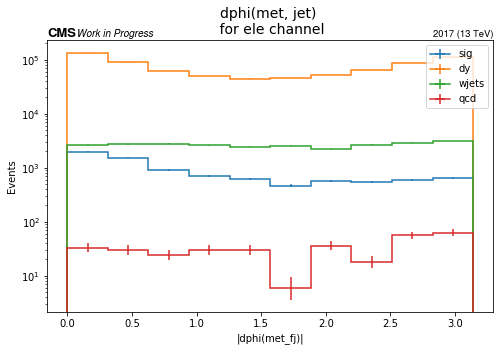

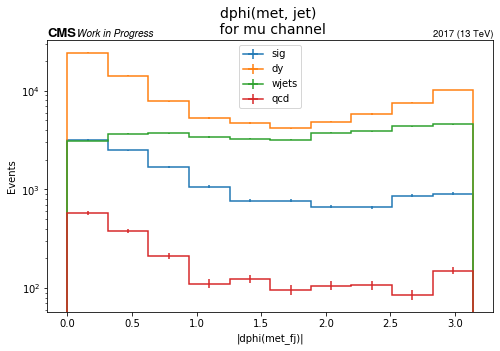

In [9]:
# dphi
hists = hist2.Hist(
    hist2.axis.Regular(10, 0, 3.14, name='dphi(met_fj)|', label='|dphi(met_fj)|', overflow=True),
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='channels', growth=True),    
)

for ch in channels:
    for sample in samples:
        hists.fill(
            abs(data[ch][sample]['met_fj_dphi']),
            sample,
            ch
        )

for ch in channels:

    fig, ax = plt.subplots(figsize=(8, 5))
    for sample in samples:
        hep.histplot(hists[{'samples':sample, 'channels': ch}], ax=ax, label=sample)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.set_title(f'dphi(met, jet) \n for {ch} channel', fontsize=14);
    plt.savefig(f'plots/{ch}_dphi_met_jet.pdf') 

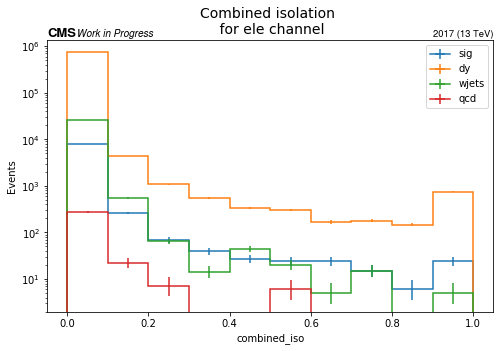

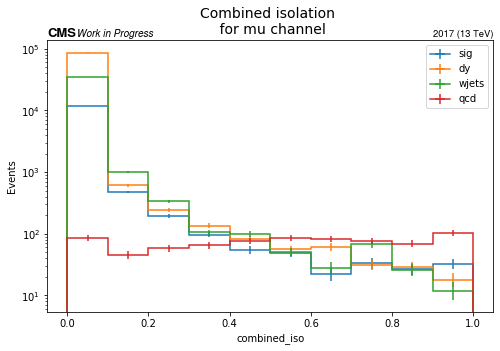

In [10]:
# combined isolation

# build the combine isolation variable using different pT conditions for electrons and muons
conditions = {}
conditions['ele'], conditions['mu'] = {}, {}

for sample in samples:
    conditions['ele'][sample] = [((data['ele'][sample]['lep_pt'] > 30) & (data['ele'][sample]['lep_pt'] < 120)), 
                      ((data['ele'][sample]['lep_pt'] <= 30) | (data['ele'][sample]['lep_pt'] >= 120))]

    conditions['mu'][sample] = [((data['mu'][sample]['lep_pt'] > 30) & (data['mu'][sample]['lep_pt'] < 55)), 
                      ((data['mu'][sample]['lep_pt'] <= 30) | (data['mu'][sample]['lep_pt'] >= 55))]
    
# actually build the combined_iso variable using the conditions specefied aboves
for ch in channels:
    for sample in samples:
        values = [data[ch][sample]['lep_isolation'], data[ch][sample]['lep_misolation']]
        data[ch][sample]['combined_iso'] = np.select(conditions[ch][sample], values)

# plot the combined isolation
hists = hist2.Hist(
    hist2.axis.Regular(10, 0, 1, name='combined_iso', label='combined_iso', overflow=True),
    hist2.axis.StrCategory([], name='samples', growth=True),
    hist2.axis.StrCategory([], name='channels', growth=True),    
)

for ch in channels:
    for sample in samples:
        hists.fill(
            data[ch][sample]['combined_iso'],
            sample,
            ch
        )

for ch in channels:

    fig, ax = plt.subplots(figsize=(8, 5))
    for sample in samples:
        hep.histplot(hists[{'samples':sample, 'channels': ch}], ax=ax, label=sample)
    hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylabel('Events')
    ax.set_title(f'Combined isolation \n for {ch} channel', fontsize=14);
    plt.savefig(f'plots/{ch}_combined_iso.pdf') 

# Investigating efficiencies and working points of the cut variables

In [11]:
# making working points and saving the counts
# the x's will contain working points as a list
# the y's will contain the counts as a list
# they are both dict() objects because they are lists per channel, per sample

x_iso, x_miso, x_met_lep, x_dphi, x_combined_iso = {}, {}, {}, {}, {}
y_iso, y_miso, y_met_lep, y_dphi, y_combined_iso = {}, {}, {}, {}, {}

for ch in channels:
    x_iso[ch], x_miso[ch], x_met_lep[ch], x_dphi[ch], x_combined_iso[ch] = {}, {}, {}, {}, {}
    y_iso[ch], y_miso[ch], y_met_lep[ch], y_dphi[ch], y_combined_iso[ch] = {}, {}, {}, {}, {}

    for sample in samples:
        x_iso[ch][sample], x_miso[ch][sample], x_met_lep[ch][sample], x_dphi[ch][sample], x_combined_iso[ch][sample] = [], [], [], [], []
        y_iso[ch][sample], y_miso[ch][sample], y_met_lep[ch][sample], y_dphi[ch][sample], y_combined_iso[ch][sample] = [], [], [], [], []
        for i in range(0, 100):
            x_iso[ch][sample].append(i*0.01)
            x_miso[ch][sample].append(i*0.01)
            x_combined_iso[ch][sample].append(i*0.01)            
            y_iso[ch][sample].append((data[ch][sample]['lep_isolation']<(i*0.01)).sum()/len(data[ch][sample])) 
            y_miso[ch][sample].append((data[ch][sample]['lep_misolation']<(i*0.01)).sum()/len(data[ch][sample])) 
            y_combined_iso[ch][sample].append((data[ch][sample]['combined_iso']<(i*0.01)).sum()/len(data[ch][sample])) 

        for i in range(0, 200):
            x_met_lep[ch][sample].append(i*0.01)
            y_met_lep[ch][sample].append(((data[ch][sample]['met']/data[ch][sample]['lep_pt'])<(i*0.01)).sum()/len(data[ch][sample])) 
        
        for i in range(0, 314):
            x_dphi[ch][sample].append(i*0.01)    
            y_dphi[ch][sample].append(((abs(data[ch][sample]['met_fj_dphi']))<(i*0.01)).sum()/len(data[ch][sample])) 

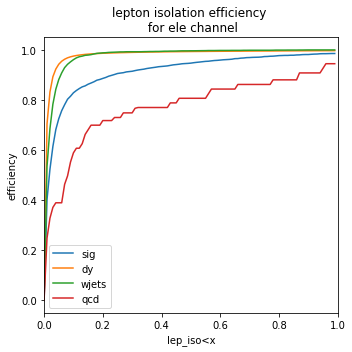

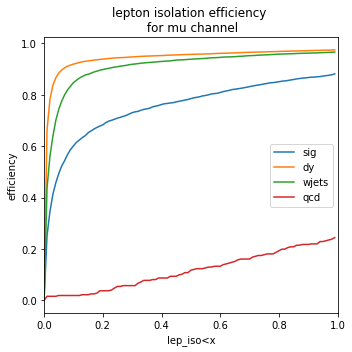

In [12]:
# lepton isolation
for ch in channels:
    fig, ax = plt.subplots(figsize=(5, 5))
    for sample in samples:
        ax.plot(x_iso[ch][sample], y_iso[ch][sample], label=sample)
    ax.set_title(f'lepton isolation efficiency \n for {ch} channel')
    ax.legend()
    ax.set_ylabel('efficiency')    
    ax.set_xlabel('lep_iso<x')        
    ax.set_xlim(0, 1)    
    fig.tight_layout()
    plt.savefig(f'plots/cut_{ch}_lep_iso.pdf') 

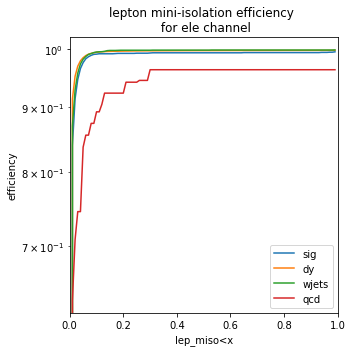

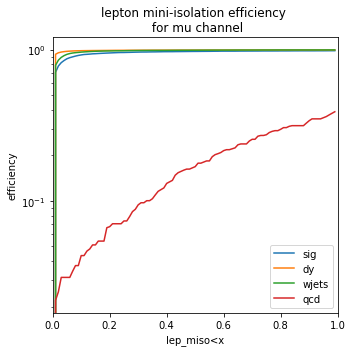

In [13]:
# lepton misolation
for ch in channels:
    fig, ax = plt.subplots(figsize=(5, 5))
    for sample in samples:
        ax.plot(x_miso[ch][sample], y_miso[ch][sample], label=sample)
    ax.set_title(f'lepton mini-isolation efficiency \n for {ch} channel')
    ax.legend()
    ax.set_ylabel('efficiency')    
    ax.set_xlabel('lep_miso<x')      
    ax.set_xlim(0, 1)   
    ax.set_yscale('log')    
    fig.tight_layout()
    plt.savefig(f'plots/cut_{ch}_lep_miso.pdf') 

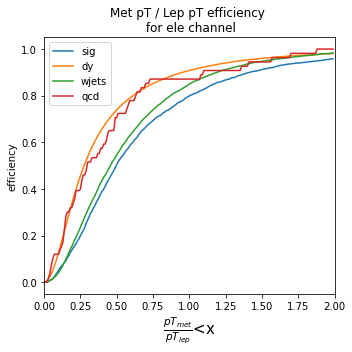

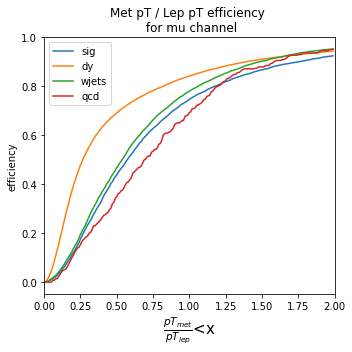

In [14]:
# met_lep
for ch in channels:
    fig, ax = plt.subplots(figsize=(5, 5))
    for sample in samples:
        ax.plot(x_met_lep[ch][sample], y_met_lep[ch][sample], label=sample)
    ax.set_title(f'Met pT / Lep pT efficiency \n for {ch} channel')
    ax.legend()
    ax.set_ylabel('efficiency')    
    ax.set_xlabel(r'$\frac{pT_{met}}{pT_{lep}}$<x', fontsize=15)    
    ax.set_xlim(0, 2)   
#     ax.set_yscale('log')    
    fig.tight_layout()
    plt.savefig(f'plots/cut_{ch}_met_over_lep.pdf') 

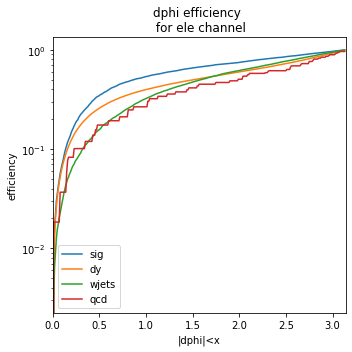

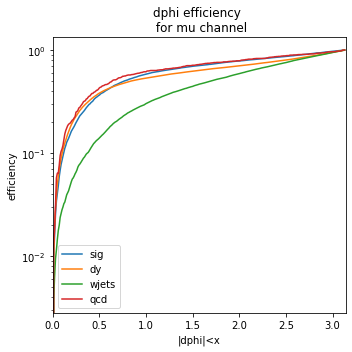

In [15]:
# dphi
for ch in channels:
    fig, ax = plt.subplots(figsize=(5, 5))
    for sample in samples:
        ax.plot(x_dphi[ch][sample], y_dphi[ch][sample], label=sample)
    ax.set_title(f'dphi efficiency \n for {ch} channel')
    ax.legend()
    ax.set_ylabel('efficiency')    
    ax.set_xlabel('|dphi|<x')    
    ax.set_xlim(0, 3.14)
    ax.set_yscale('log')    
    fig.tight_layout()
    plt.savefig(f'plots/cut_{ch}_dphi.pdf') 

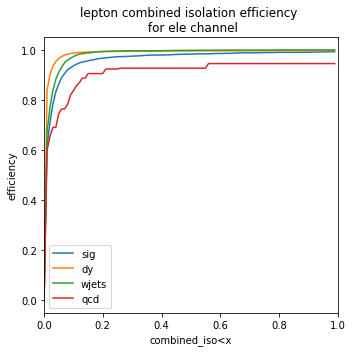

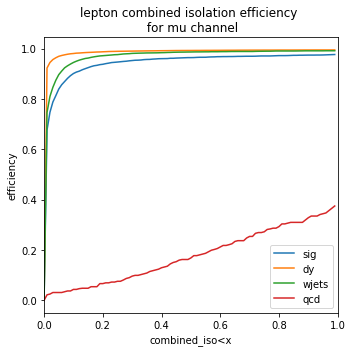

In [16]:
# combined_iso
for ch in channels:
    fig, ax = plt.subplots(figsize=(5, 5))
    for sample in samples:
        ax.plot(x_combined_iso[ch][sample], y_combined_iso[ch][sample], label=sample)
    ax.set_title(f'lepton combined isolation efficiency \n for {ch} channel')
    ax.legend()
    ax.set_ylabel('efficiency')    
    ax.set_xlabel('combined_iso<x')
    ax.set_xlim(0, 1)
#     ax.set_yscale('log')
    fig.tight_layout()
    plt.savefig(f'plots/cut_{ch}_combined_iso.pdf') 

# 2d plots

In [17]:
import pickle as pkl
import pyarrow.parquet as pq
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import sys
import glob
import shutil
import pathlib
from typing import List, Optional

import argparse
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

In [18]:
# isolation

lep = 'ele'
# lep = 'mu'

x = []
y_iso, y_ax = [], []

for i in range(0, 100):
    x.append(i*0.01)
    
    if lep=='ele':    
        cut = (data_ele['sig']['lep_isolation']<(i*0.01))
        y_iso.append((cut).sum()/len(data_ele['sig']))     
        y_ax.append(data_ele['sig']['lep_pt'][cut].to_numpy())
    else:
        cut = (data_mu['sig']['lep_isolation']<(i*0.01))    
        y_iso.append((cut).sum()/len(data_mu['sig']))
        y_ax.append(data_mu['sig']['lep_pt'][cut].to_numpy())  
    
x_tuple = []
y_tuple = []

for i, elem in enumerate(y_ax):
    for j in elem:
        x_tuple.append(x[i])
        y_tuple.append(j)
        
hists = hist2.Hist(
    hist2.axis.Regular(20*5, 0, 1, name='lep_reliso<x', label='lep_reliso<x', overflow=True),
    hist2.axis.Regular(20*5, 0, 350, name='lep_pt', label='lep_pt', overflow=True),
#     hist2.axis.StrCategory([], name='samples', growth=True),
)

hists.fill(
    x_tuple,
    y_tuple,
);

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1000))
# ax.set_xlabel(f"{vars[0]}")
# ax.set_ylabel(f"{vars[1]}");
ax.set_title(f'signal efficiency');
plt.savefig(f'data/cut_2d_iso.pdf')        

NameError: name 'data_ele' is not defined

In [ ]:
# misolation

lep = 'ele'
# lep = 'mu'

x = []
y_iso, y_ax = [], []

for i in range(0, 100):
    x.append(i*0.01)
    
    if lep=='ele':
        cut = (data_ele['sig']['lep_misolation']<(i*0.01))
        y_iso.append((cut).sum()/len(data_ele['sig']))     
        y_ax.append(data_ele['sig']['lep_pt'][cut].to_numpy())        
    else:
        cut = (data_mu['sig']['lep_misolation']<(i*0.01))    
        y_iso.append((cut).sum()/len(data_mu['sig']))
        y_ax.append(data_mu['sig']['lep_pt'][cut].to_numpy())  
    
x_tuple = []
y_tuple = []

for i, elem in enumerate(y_ax):
    for j in elem:
        x_tuple.append(x[i])
        y_tuple.append(j)
        
hists = hist2.Hist(
    hist2.axis.Regular(20*5, 0, 1, name='lep_misolation<x', label='lep_misolation<x', overflow=True),
    hist2.axis.Regular(20*5, 0, 350, name='lep_pt', label='lep_pt', overflow=True),
#     hist2.axis.StrCategory([], name='samples', growth=True),
)

hists.fill(
    x_tuple,
    y_tuple,
);

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1000))
# ax.set_xlabel(f"{vars[0]}")
# ax.set_ylabel(f"{vars[1]}");
ax.set_title(f'signal efficiency for {lep}');
plt.savefig(f'data/cut_2d_miso.pdf')        

# sig vs bkg efficiency

In [ ]:
# isolation & misolation
x = []
y_ele_iso_sig, y_ele_iso_dy, y_ele_iso_wjets, y_ele_iso_qcd = [], [], [], []
y_ele_miso_sig, y_ele_miso_dy, y_ele_miso_wjets, y_ele_miso_qcd = [], [], [], []

for i in range(0, 100):
    x.append(i*0.01)
    y_ele_iso_sig.append((data_ele['sig']['lep_isolation']<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_iso_dy.append((data_ele['dy']['lep_isolation']<(i*0.01)).sum()/len(data_ele['dy'])) 
    y_ele_iso_wjets.append((data_ele['wjets']['lep_isolation']<(i*0.01)).sum()/len(data_ele['wjets'])) 
    y_ele_iso_qcd.append((data_ele['qcd']['lep_isolation']<(i*0.01)).sum()/len(data_ele['qcd'])) 

    y_ele_miso_sig.append((data_ele['sig']['lep_misolation']<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_miso_dy.append((data_ele['dy']['lep_misolation']<(i*0.01)).sum()/len(data_ele['dy'])) 
    y_ele_miso_wjets.append((data_ele['wjets']['lep_misolation']<(i*0.01)).sum()/len(data_ele['wjets'])) 
    y_ele_miso_qcd.append((data_ele['qcd']['lep_misolation']<(i*0.01)).sum()/len(data_ele['qcd'])) 

# met.pt/lep.pt cut
x_met = []
y_ele_met_sig, y_ele_met_dy, y_ele_met_wjets, y_ele_met_qcd = [], [], [], []

met_lep_ele_sig = data_ele['sig']['met']/data_ele['sig']['lep_pt']
met_lep_ele_dy = data_ele['dy']['met']/data_ele['dy']['lep_pt']
met_lep_ele_wjets = data_ele['wjets']['met']/data_ele['wjets']['lep_pt']
met_lep_ele_qcd = data_ele['qcd']['met']/data_ele['qcd']['lep_pt']

for i in range(0, 250):
    x_met.append(i*0.01)
    y_ele_met_sig.append((met_lep_ele_sig>(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_met_dy.append((met_lep_ele_dy>(i*0.01)).sum()/len(data_ele['dy'])) 
    y_ele_met_wjets.append((met_lep_ele_wjets>(i*0.01)).sum()/len(data_ele['wjets'])) 
    y_ele_met_qcd.append((met_lep_ele_qcd>(i*0.01)).sum()/len(data_ele['qcd'])) 

# dphi
x_dphi = []
y_ele_dphi_sig, y_ele_dphi_dy, y_ele_dphi_wjets, y_ele_dphi_qcd = [], [], [], []

for i in range(314):
    x_dphi.append(i*0.01)
    y_ele_dphi_sig.append((abs(data_ele['sig']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_dphi_dy.append((abs(data_ele['dy']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['dy'])) 
    y_ele_dphi_wjets.append((abs(data_ele['wjets']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['wjets'])) 
    y_ele_dphi_qcd.append((abs(data_ele['qcd']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['qcd'])) 
    
# plot
xlabels = ['lep_reliso<x', 'lep_misolation<x', 'met_pt/lep_pt>x', '|met_fj_dphi|<x']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(x, y_ele_iso_sig, label='sig')
axs[0, 0].plot(x, y_ele_iso_dy, label='dy')
axs[0, 0].plot(x, y_ele_iso_wjets, label='wjets')
axs[0, 0].plot(x, y_ele_iso_qcd, label='qcd')
axs[0, 0].set_title('Signal & Background efficiencies')

axs[0, 1].plot(x, y_ele_miso_sig, label='sig')
axs[0, 1].plot(x, y_ele_miso_dy, label='dy')
axs[0, 1].plot(x, y_ele_miso_wjets, label='wjets')
axs[0, 1].plot(x, y_ele_miso_qcd, label='qcd')
axs[0, 1].set_title('Signal & Background efficiencies')

axs[1, 0].plot(x_met, y_ele_met_sig, label='sig')
axs[1, 0].plot(x_met, y_ele_met_dy, label='dy')
axs[1, 0].plot(x_met, y_ele_met_wjets, label='wjets')
axs[1, 0].plot(x_met, y_ele_met_qcd, label='qcd')
#axs[1, 0].set_title('Signal efficiency')

axs[1, 1].plot(x_dphi, y_ele_dphi_sig, label='sig')
axs[1, 1].plot(x_dphi, y_ele_dphi_dy, label='dy')
axs[1, 1].plot(x_dphi, y_ele_dphi_wjets, label='wjets')
axs[1, 1].plot(x_dphi, y_ele_dphi_qcd, label='qcd')
# axs[1, 1].set_title('Signal efficiency')

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=xlabels[i], ylabel='efficiency')
    ax.legend()

# fig.tight_layout()
plt.savefig('data/cut_all_sig_bkg.pdf')

In [ ]:
# total background

data_ele['tot_bkg'] = pd.concat([data_ele['dy'], data_ele['wjets'], data_ele['qcd']])

# isolation & misolation
x = []
y_ele_iso_sig, y_ele_iso_bkg = [], []
y_ele_miso_sig, y_ele_miso_bkg = [], []

for i in range(0, 100):
    x.append(i*0.01)
    y_ele_iso_sig.append((data_ele['sig']['lep_isolation']<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_iso_bkg.append((data_ele['tot_bkg']['lep_isolation']<(i*0.01)).sum()/len(data_ele['tot_bkg'])) 

    y_ele_miso_sig.append((data_ele['sig']['lep_misolation']<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_miso_bkg.append((data_ele['tot_bkg']['lep_misolation']<(i*0.01)).sum()/len(data_ele['tot_bkg'])) 

# met.pt/lep.pt cut
x_met = []
y_ele_met_sig, y_ele_met_bkg = [], []

met_lep_ele_sig = data_ele['sig']['met']/data_ele['sig']['lep_pt']
met_lep_ele_bkg = data_ele['tot_bkg']['met']/data_ele['tot_bkg']['lep_pt']

for i in range(0, 250):
    x_met.append(i*0.01)
    y_ele_met_sig.append((met_lep_ele_sig>(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_met_bkg.append((met_lep_ele_bkg>(i*0.01)).sum()/len(data_ele['tot_bkg'])) 

# dphi
x_dphi = []
y_ele_dphi_sig, y_ele_dphi_bkg = [], []

for i in range(314):
    x_dphi.append(i*0.01)
    y_ele_dphi_sig.append((abs(data_ele['sig']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['sig'])) 
    y_ele_dphi_bkg.append((abs(data_ele['tot_bkg']['met_fj_dphi'])<(i*0.01)).sum()/len(data_ele['tot_bkg'])) 
    
# plot
xlabels = ['lep_reliso<x', 'lep_misolation<x', 'met_pt/lep_pt>x', '|met_fj_dphi|<x']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(x, y_ele_iso_sig, label='sig')
axs[0, 0].plot(x, y_ele_iso_bkg, label='tot_bkg')
axs[0, 0].set_title('Signal & Background efficiencies')

axs[0, 1].plot(x, y_ele_miso_sig, label='sig')
axs[0, 1].plot(x, y_ele_miso_bkg, label='tot_bkg')
axs[0, 1].set_title('Signal & Background efficiencies')

axs[1, 0].plot(x_met, y_ele_met_sig, label='sig')
axs[1, 0].plot(x_met, y_ele_met_bkg, label='tot_bkg')
#axs[1, 0].set_title('Signal efficiency')

axs[1, 1].plot(x_dphi, y_ele_dphi_sig, label='sig')
axs[1, 1].plot(x_dphi, y_ele_dphi_bkg, label='tot_bkg')
# axs[1, 1].set_title('Signal efficiency')

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=xlabels[i], ylabel='efficiency')
    ax.legend()

# fig.tight_layout()
plt.savefig('data/cut_all_sig_tot_bkg.pdf')

In [ ]:
# s/sqrt(b)

lep = 'ele'
# lep = 'mu'

x = []
y_ax = []
s_over_b = []

for i in range(0, 100):
    x.append(i*0.01)
    
    if lep=='ele':
        cut_sig = (data_ele['sig']['lep_misolation']<(i*0.01))
        cut_bkg = (data_ele['tot_bkg']['lep_misolation']<(i*0.01))
        y_ax.append(pd.concat(([data_ele['sig']['lep_pt'][cut_sig], data_ele['tot_bkg']['lep_pt'][cut_bkg]])).to_numpy()) 
#         s_over_b.append((data_ele['sig']['lep_pt'][cut_sig]).sum() / np.sqrt((data_ele['tot_bkg']['lep_pt'][cut_bkg]).sum()))

    else:
        cut = (data_mu['sig']['lep_misolation']<(i*0.01))    
        y_ax.append(data_mu['sig']['lep_pt'][cut].to_numpy())  
    
x_tuple = []
y_tuple = []

for i, elem in enumerate(y_ax):
    for j in elem:
        x_tuple.append(x[i])
        y_tuple.append(j)
        
hists = hist2.Hist(
    hist2.axis.Regular(20*5, 0, 1, name='lep_misolation<x', label='lep_misolation<x', overflow=True),
    hist2.axis.Regular(20*5, 0, 350, name='lep_pt', label='lep_pt', overflow=True),
#     hist2.axis.StrCategory([], name='samples', growth=True),
)

hists.fill(
    x_tuple,
    y_tuple,
);

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(hists, ax=ax, cmap="plasma")#, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1000))
# ax.set_xlabel(f"{vars[0]}")
# ax.set_ylabel(f"{vars[1]}");
ax.set_title(f's/sqrt(b) for {lep}');
plt.savefig(f'data/cut_s_over_b.pdf')    

## 1d-histograms

In [ ]:
# isolation & misolation
x = []
y_ele_iso_sig, y_ele_iso_dy, y_ele_iso_wjets, y_ele_iso_qcd = [], [], [], []
y_ele_miso_sig, y_ele_miso_dy, y_ele_miso_wjets, y_ele_miso_qcd = [], [], [], []

for i in range(0, 100):

    
    
    
data_ele['sig']['lep_isolation']
data_ele['dy']['lep_isolation']
data_ele['wjets']['lep_isolation']
data_ele['qcd']['lep_isolation']


In [ ]:
data_ele['sig']['lep_isolation']

In [ ]:
len(data_ele['sig']['lep_isolation'])

In [ ]:
data_ele['sig']['lep_isolation']

In [ ]:
xlabels = ['lep_reliso', 'lep_misolation', 'met_pt/lep_pt', '|met_fj_dphi|']

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(range(len(data_ele['sig']['lep_isolation'])), data_ele['sig']['lep_isolation'], label='sig')
# axs[0, 0].plot(x, y_ele_iso_bkg, label='tot_bkg')
# axs[0, 0].set_title('Signal & Background efficiencies')

# axs[0, 1].plot(x, y_ele_miso_sig, label='sig')
# axs[0, 1].plot(x, y_ele_miso_bkg, label='tot_bkg')
# axs[0, 1].set_title('Signal & Background efficiencies')

# axs[1, 0].plot(x_met, y_ele_met_sig, label='sig')
# axs[1, 0].plot(x_met, y_ele_met_bkg, label='tot_bkg')
# #axs[1, 0].set_title('Signal efficiency')

# axs[1, 1].plot(x_dphi, y_ele_dphi_sig, label='sig')
# axs[1, 1].plot(x_dphi, y_ele_dphi_bkg, label='tot_bkg')
# axs[1, 1].set_title('Signal efficiency')

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=xlabels[i], ylabel='efficiency')
    ax.legend()